### Sentiment analysis on reviews data
Kei Sato

ML310B - Advanced Machine Learning

March 25, 2019


We will be using reviews data to develop a sentiment analyzer, such that given a document, the model can predict if the review is positive (sentiment = 1) or negative (sentiment = 0)


In [1]:
# Load the data...
import pandas as pd
from nltk.tokenize import word_tokenize

data = pd.read_csv('data/Reviews.csv')

print("Number of positive and negative review", '\n', data["sentiment"].value_counts())
data.head()

Number of positive and negative review 
 1    25000
0    25000
Name: sentiment, dtype: int64


,review,sentiment
0,My family and I normally do not watch local mo...,1
1,"Believe it or not, this was at one time the wo...",0
2,"After some internet surfing, I found the ""Home...",0
3,One of the most unheralded great works of anim...,1
4,"It was the Sixties, and anyone with long hair ...",0


#### Initial Text Processing
The reviews corpus has 5000 reviews and is evenly split between positive and negative reviews, so that it contains 2500 positive and 2500 negative reviews.  Before doing any more data exploration, we process the text using standard techniques.  Much of this code was taken from the Lesson 8 HW assignment.

The first step is apply some basic text processing.  This function will transform all the letters to lowercase and replace any punctuation or symbols with spaces.  At this step we will also remove English stop words.  Because this corpus contains some <br \> HTML elements, we will strip those out from the text as well.  This function will return the words in a tokenized format such each word is an element in an array.  After cleaning the text, lemmatization is applied. 

I did apply stemming to the dataset, but that produced too many non words and so it has been omitted from the text processing steps.

In [55]:
# Taken Lesson 8 HW assignment
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

replace_re_by_space = re.compile('[/(){}\[\]\|@,;]')
delete_re_symbols = re.compile('[^0-9a-z #+_]')
stop_words = set(stopwords.words('english'))
stop_words.remove('but')

def combine_tokened_words(tokened_words):
    length_of_string=len(tokened_words)
    text_new=""
    for w in tokened_words:
        if w!=tokened_words[length_of_string-1]:
             text_new=text_new+w+" " # when w is not the last word so separate by whitespace
        else:
            text_new=text_new+w
    return text_new

# converts to lowercase and removes <br />, punctuation, stop words, and numbers
def text_processing(text):
    text = text.lower()
    text = text.replace("<br />", '')
    text = re.sub(replace_re_by_space.pattern, ' ', text)
    text = re.sub(delete_re_symbols.pattern, '', text)
    token_word = word_tokenize(text)
    
    # filtered_sentence contain all words that are not in stopwords dictionary    
    filtered_sentence = [w for w in token_word if not w in stop_words]
    return filtered_sentence

# Lemmatizes words
def text_lemmatization(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    text = list(map(lambda word: wordnet_lemmatizer.lemmatize(word), text))
    return text


test_data = data[:500].copy(deep=True)
test_data["review"] = test_data["review"].apply(lambda text:
                                                combine_tokened_words(
                                                text_lemmatization(
                                                text_processing(text))))

{'itself', 'been', 'out', 'having', 'at', 'now', 'll', 'doing', 'into', 'the', 'down', 'both', 'be', 'some', "isn't", 'wasn', 'we', "doesn't", 'himself', 'theirs', 'same', 'how', "mustn't", 'shan', 'or', "hadn't", 'couldn', 'few', 'any', 'own', 'them', 'through', 'other', 'these', 'just', 'over', "should've", 's', 'ours', 'during', 'those', 'below', 'wouldn', 'who', 'd', "you've", 'him', 'o', "you'll", 'needn', 'weren', 'have', 'if', 'herself', 'hadn', 'until', 'me', 'such', 'do', 'whom', "hasn't", 'too', "didn't", 'will', "won't", "mightn't", 'so', 'it', 'as', "you're", 'aren', 'from', 'what', 've', 'very', "wouldn't", 'under', 'while', "wasn't", 'there', 'then', "you'd", 'don', "she's", 'isn', "couldn't", 'between', 'again', 'with', 'ma', 'in', 'each', 'of', 't', 'her', 'hasn', 'yours', 'nor', 'but', 'off', 'against', 'no', 'was', "aren't", 'you', 'didn', 'mightn', "shouldn't", "weren't", 'yourself', 'myself', 'yourselves', 'mustn', 'his', 'can', 'its', 'm', 'most', 'once', 'should',

KeyError: 'but'

#### Data exploration
Below is some initial data exploration.  We can see that the average length of positive and negative reviews is roughtly the same.  The ten most frequently occuring words are also very similar across between the sets of positive and negative reviews.  

In [48]:
import numpy as np
from collections import Counter 
from functools import reduce

# Get average length of reviews
def get_avg_length_review(data, sentiment):
    relevant_reviews = data.loc[data["sentiment"] == sentiment]["review"]
    avg_review_length = list(map(lambda review: len(review.split()), relevant_reviews))
    return int(np.mean(avg_review_length))
print("Average word count of negative reviews:", get_avg_length_review(test_data, 0))
print("Average word count of positive reviews:", get_avg_length_review(test_data, 1))

# Get 10 most frequently occuring words
def get_top_words(data, sentiment):
    relevant_reviews = data.loc[data["sentiment"] == sentiment]["review"]
    all_relevant_reviews = reduce(lambda accum, curr: accum + curr, relevant_reviews)
    return Counter(all_relevant_reviews.split()).most_common(10)
print('\n')  
print("Top 10 most common words in negative reviews", get_top_words(test_data, 0))
print("Top 10 most common words in positive reviews", get_top_words(test_data, 1))

Average word count of negative reviews: 137
Average word count of positive reviews: 122


Top 10 most common words in negative reviews [('movie', 627), ('film', 427), ('one', 258), ('like', 237), ('get', 177), ('even', 159), ('character', 158), ('good', 156), ('would', 153), ('time', 137)]
Top 10 most common words in positive reviews [('movie', 409), ('film', 407), ('one', 268), ('like', 173), ('time', 150), ('character', 140), ('see', 139), ('story', 130), ('well', 122), ('good', 119)]


#### Running the model and cross validation

ngram range (1, 1)
Best params {'degree': 1, 'gamma': 'auto', 'kernel': 'linear'}
accuracy 0.6933333333333334
FPR: [0.         0.43478261 1.        ]
TPR: [0.         0.80246914 1.        ]


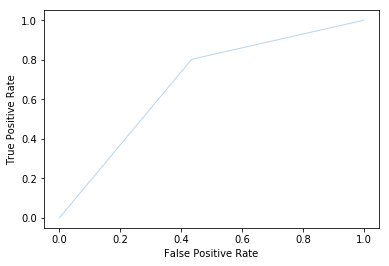

INCORRECT PREDICTION 1 family normally watch local movie simple reason poorly made lack depth worth timethe trailer nasaan ka man caught attention daughter law daughter took time watch afternoon movie exceeded expectation cinematography good story beautiful acting awesome jericho rosales really good so claudinebarretto fact despised diether ocampo prof effective role never touched moved affected local movie imagine cynic like dabbing eye end movie congratulation star cinema way go jericho claudine


KeyError: 1

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.svm import SVC

from sklearn.cluster import KMeans


def graph_roc(y_true, y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    print("FPR:", fpr)
    print("TPR:", tpr)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='test')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
def get_incorrect_preds(data, y_true, y_pred):
    for i in range(0, len(y_true)):
        if y_true[i] == y_pred[i]:
            print("CORRECT PREDICTION", y_true[i], data[i] )
        else:
            print("INCORRECT PREDICTION", y_true[i], data[i] )
        


def run_model_cv(data):   
    x_train, x_test, y_train, y_test = train_test_split(
        data["review"],
        data["sentiment"],
        test_size=0.3,
        random_state=42
    )
    
    ngrams = [
        (1, 1),
        (1, 2),
        (1, 3),
        (1, 4),
        (1, 5)
    ]
    
    for ngram_param in ngrams:
        print("ngram range", ngram_param)
        tfid_vectorizer = TfidfVectorizer(min_df=4, max_df=0.8, use_idf=True, ngram_range=ngram_param).fit(x_train)
        _x_train = tfid_vectorizer.transform(x_train)
        _x_test = tfid_vectorizer.transform(x_test)
        
#         kmeans = KMeans(n_clusters=2, random_state=0).fit(_x_train)
#         y_pred = kmeans.predict(_x_test)
                
        cv_clf = GridSearchCV(
                    SVC(),
                    [
                        {
                            "kernel": ["linear", "poly"],
                            "degree": [1, 2],
                            "gamma": ["auto", "scale"]
                        }
                    ],
                    cv=5,
                    refit=True
                )
        cv_clf.fit(_x_train, y_train)
        print("Best params", cv_clf.best_params_)
        
        y_pred = cv_clf.predict(_x_test)
        print("accuracy", metrics.accuracy_score(y_test, y_pred))
        graph_roc(y_test, y_pred)
        get_incorrect_preds(x_test, y_test, y_pred)


    
run_model_cv(test_data)
